<a href="https://colab.research.google.com/github/Zivvvo/melanoma_classifier/blob/master/SC_model_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
tf.__version__

'2.2.0'

In [ ]:
from tensorflow import keras

In [ ]:
DataGenerator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255.0)

In [ ]:
import os
base_dir = os.getcwd()
train_dir = os.path.join(base_dir, 'train')
print(train_dir)

/content/train


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
cd /content/drive/My\ Drive/Colab\ Notebooks/SC_classifier

/content/drive/My Drive/Colab Notebooks/SC_classifier


In [ ]:
dataset = DataGenerator.flow_from_directory("train", classes = ['benign', 'malignant'])

Found 2637 images belonging to 2 classes.


83
AxesImage(54,36;334.8x217.44) [1. 0.]
(256, 256, 3)
[1. 0.]


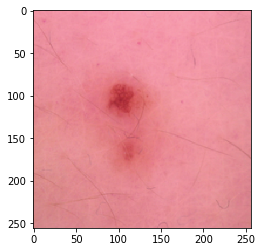

In [ ]:
data = None
labels = None
print(len(dataset))
data, labels = dataset[0]
print(plt.imshow(data[0]),labels[0])
print(data[0].shape)
print(labels[0])

In [ ]:
from keras.models import Input, Model
from keras.layers import Activation, Dropout, Dense, Conv2D, Flatten, MaxPooling2D, BatchNormalization, SeparableConv2D, add, GlobalAveragePooling2D

def sc_model(input_shape):
    X_input = Input(input_shape)
    
    X = Conv2D(32, kernel_size = 3, strides = 2, padding = 'same', input_shape = input_shape)(X_input)
    X = BatchNormalization()(X)
    X = Activation("relu")(X)
    
    X = Conv2D(64, kernel_size = 3, padding = "same")(X)
    X = BatchNormalization()(X)
    X = Activation("relu")(X)
    
    previous_block_activation = X #residual
    
    for size in [128,256,512,728]:
        X = Activation("relu")(X)
        X = SeparableConv2D(size, 3, padding = "same")(X)
        X = BatchNormalization()(X)
            
        X = Activation("relu")(X)
        X = SeparableConv2D(size, 3, padding = "same")(X)
        X = BatchNormalization()(X)
        
        X = MaxPooling2D(3, strides = 2, padding = "same")(X)
        
        #add residual
        
        residual = Conv2D(size, 1, strides = 2, padding = "same")(previous_block_activation)
        
        X = add([X, residual])
        previous_block_activation = X #a copy of the next residual
    
    X = SeparableConv2D(1024, 3, padding = "same")(X)
    
    X = BatchNormalization()(X)
    
    X = Activation("relu")(X)
    
    X = GlobalAveragePooling2D()(X)
    
    X = Dropout(0.5)(X)
    
    X = Dense(2, activation = "softmax")(X)
    
    model = Model(inputs = X_input, outputs = X, name = "nn_model")
    
    return model


Using TensorFlow backend.


In [ ]:
sc_model = sc_model(data[0].shape)

In [ ]:
sc_model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
sc_model.summary()

Model: "nn_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 32) 0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [ ]:
from keras import backend as K
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("latest_model.hdf5", monitor = 'loss', verbose = 1, save_best_only=True, mode='auto', period = 1)

In [ ]:
sc_model.fit(dataset, epochs = 10, callbacks = [checkpoint])

Epoch 1/10
83/83 [==============================] - 891s 11s/step - loss: 0.5438 - accuracy: 0.7486

Epoch 00001: loss improved from inf to 0.54534, saving model to latest_model.hdf5
Epoch 2/10
83/83 [==============================] - 89s 1s/step - loss: 0.4438 - accuracy: 0.7903

Epoch 00002: loss improved from 0.54534 to 0.44315, saving model to latest_model.hdf5
Epoch 3/10
83/83 [==============================] - 89s 1s/step - loss: 0.4280 - accuracy: 0.7975

Epoch 00003: loss improved from 0.44315 to 0.42574, saving model to latest_model.hdf5
Epoch 4/10
83/83 [==============================] - 89s 1s/step - loss: 0.4087 - accuracy: 0.8104

Epoch 00004: loss improved from 0.42574 to 0.40664, saving model to latest_model.hdf5
Epoch 5/10
83/83 [==============================] - 89s 1s/step - loss: 0.3878 - accuracy: 0.8233

Epoch 00005: loss improved from 0.40664 to 0.38825, saving model to latest_model.hdf5
Epoch 6/10
83/83 [==============================] - 89s 1s/step - loss: 0.347

In [ ]:
sc_model.fit(dataset, epochs = 2, callbacks = [checkpoint])

Epoch 1/2
83/83 [==============================] - 89s 1s/step - loss: 0.3204 - accuracy: 0.8510

Epoch 00001: loss improved from 0.32637 to 0.32000, saving model to latest_model.hdf5
Epoch 2/2
83/83 [==============================] - 89s 1s/step - loss: 0.2885 - accuracy: 0.8646

Epoch 00002: loss improved from 0.32000 to 0.28783, saving model to latest_model.hdf5


In [ ]:
sc_model.save("model_architecture.h5")

In [ ]:
scores = sc_model.evaluate(dataset)

83/83 [==============================] - 19s 226ms/step


In [ ]:
print(scores)

[0.1274801790714264, 0.8475540280342102]


In [ ]:
test_set = DataGenerator.flow_from_directory("test", classes = ['benign', 'malignant'])

Found 660 images belonging to 2 classes.


In [ ]:
test_scores = sc_model.evaluate(test_set)

21/21 [==============================] - 249s 12s/step


In [ ]:
print(test_scores)

[0.44773513078689575, 0.8181818127632141]


Prediction:[[0.03459048 0.96540946]], actual result: [0. 1.]


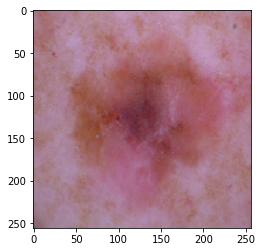

In [ ]:
#predictions on test set examples
batch_num = 18
index_num = 14

x = dataset[batch_num][0][index_num]
prediction = sc_model.predict(x[np.newaxis, ...])
print("Prediction:"+ str(prediction) + ", actual result: "+ str(dataset[batch_num][1][index_num]))
plt.imshow(x)